In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

%matplotlib inline

## 2-1: CWRU Dataset

In [2]:
# Normal dataset
!wget -q https://engineering.case.edu/sites/default/files/99.mat
# Inner-Race-falut dataset
!wget -q https://engineering.case.edu/sites/default/files/107.mat
# Ball-falut dataset
!wget -q https://engineering.case.edu/sites/default/files/120.mat
# Outer-race-falut dataset
!wget -q https://engineering.case.edu/sites/default/files/132.mat

In [3]:
from scipy.io import loadmat

In [4]:
# Loading normal data
data_n = loadmat('99.mat')
cols_n = list(data_n.keys())[-4:]

# Loading inner race fault data
data_fi = loadmat('107.mat')
cols_fi = list(data_fi.keys())[-4:-1]

# Loading ball normal data
data_fb = loadmat('120.mat')
cols_fb = list(data_fb.keys())[-4:]

# Loading outer race fault data
data_fo = loadmat('132.mat')
cols_fo = list(data_fo.keys())[-4:-1]

In [5]:
print(f'normal data consists of {cols_n}', end='\n\n')
print(f'inner race fault data consista of {cols_fi}', end='\n\n')
print(f'ball fault data consists of {cols_fb}', end='\n\n')
print(f'outer race fault data consists of {cols_fo}')

normal data consists of ['X098_DE_time', 'X098_FE_time', 'X099_DE_time', 'X099_FE_time']

inner race fault data consista of ['X107_DE_time', 'X107_FE_time', 'X107_BA_time']

ball fault data consists of ['X120_DE_time', 'X120_FE_time', 'X120_BA_time', 'X120RPM']

outer race fault data consists of ['X132_DE_time', 'X132_FE_time', 'X132_BA_time']


In [6]:
# Choosing the right data
data_n = data_n['X099_DE_time']
data_fi = data_fi['X107_DE_time']
data_fb = data_fb['X120_DE_time']
data_fo = data_fo['X132_DE_time']

Deviding the data

In [7]:
M = 250
N = 200
signals = {'normal': data_n, 'inner fault': data_fi,
           'ball fault': data_fb, 'outter fault': data_fo}
data_names = signals.keys()
matrices = dict()
for i,name in enumerate(data_names):

    mat = np.zeros((M,N))
    for j in range(M):

        mat[j,:] = signals[name][j:j+N].reshape(-1,)
    matrices[name] = mat

In [8]:
met_name = matrices.keys()
for i, n in enumerate(met_name):

    print(f'From {n} data, {matrices[n].shape[0]} signals with length of {matrices[n].shape[1]} are extracted')

From normal data, 250 signals with length of 200 are extracted
From inner fault data, 250 signals with length of 200 are extracted
From ball fault data, 250 signals with length of 200 are extracted
From outter fault data, 250 signals with length of 200 are extracted


Extracting Features

In [9]:
from scipy import stats

In [10]:
# Class for calculating features
class Features:

    def __init__(self,matrix):
        self.matrix = matrix
        self._extract()

    def _extract(self):

        self.features = {
            'standard deviation': stats.tstd(self.matrix, axis=1),
            'peak': np.max(self.matrix, axis=1),
            'skewness': stats.skew(self.matrix, axis=1),
            'mean': np.mean(self.matrix, axis=1),
            'absolute mean': np.mean(np.abs(self.matrix), axis=1),
            'root mean square': np.sqrt(np.mean(np.square(self.matrix), axis=1)),
            'square root mean': np.square(np.mean(np.sqrt(np.abs(self.matrix)), axis=1)),
            'kurtosis': stats.kurtosis(self.matrix, axis=1),
            'crest factor': np.max(self.matrix, axis=1) / np.sqrt(np.mean(np.square(self.matrix), axis=1)),
            'clearance factor': np.max(self.matrix, axis=1) / np.square(np.mean(np.sqrt(np.abs(self.matrix)), axis=1)),
            'peak to peak': np.max(self.matrix, axis=1) - np.min(self.matrix, axis=1),
            'shape factor': np.sqrt(np.mean(np.square(self.matrix), axis=1)) / np.mean(np.abs(self.matrix), axis=1),
            'impact factor': np.sqrt(np.mean(np.square(self.matrix), axis=1)) / np.mean(np.abs(self.matrix), axis=1),
            'impulse factor': np.abs(np.mean(self.matrix, axis=1)) / np.mean(np.abs(self.matrix), axis=1)
        }

    def __getitem__(self,key):
        return self.features[key]


feature_dic = dict()
for n in met_name:

    feature_dic[n] = Features(matrices[n])

Creating a dataframe for features

In [11]:
data_frames = dict()
for i,n in enumerate(met_name):

    data_frames[n] = pd.DataFrame(feature_dic[n].features)
    data_frames[n]['label'] = i
    print(f'Label of \'{n}\' data is {i}')

# Stacking both datasets
df = pd.concat ([data_frames[n] for n in met_name], ignore_index=True)
df.head()

Label of 'normal' data is 0
Label of 'inner fault' data is 1
Label of 'ball fault' data is 2
Label of 'outter fault' data is 3


,standard deviation,peak,skewness,mean,absolute mean,root mean square,square root mean,kurtosis,crest factor,clearance factor,peak to peak,shape factor,impact factor,impulse factor,label
0,0.065162,0.179826,-0.102434,0.016275,0.051197,0.067005,0.041341,0.205579,2.683775,4.349826,0.355481,1.308760,1.308760,0.317890,0
1,0.065124,0.179826,-0.101089,0.016218,0.051140,0.066955,0.041293,0.211600,2.685784,4.354910,0.355481,1.309248,1.309248,0.317125,0
2,0.065046,0.179826,-0.095520,0.016050,0.050972,0.066839,0.041131,0.224659,2.690446,4.371997,0.355481,1.311286,1.311286,0.314875,0
3,0.065087,0.179826,-0.092039,0.015959,0.051063,0.066857,0.041302,0.216531,2.689711,4.353963,0.355481,1.309313,1.309313,0.312538,0
4,0.065158,0.179826,-0.091184,0.015882,0.051140,0.066907,0.041377,0.205829,2.687688,4.346023,0.355481,1.308321,1.308321,0.310557,0


Splitting the data

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Trian & Test split
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('label', axis=1, inplace=False).values,
    df.label.values,
    test_size = 0.15,
    shuffle = True,
    random_state = 54
)

# Train & Validation split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size = .15,
    random_state = 54
)


print(f'Size of Train data is:\nX --> {x_train.shape}\ny --> {y_train.shape}')
print(f'Size of Validation data is:\nX --> {x_val.shape}\ny --> {y_val.shape}')
print(f'Size of Test data is:\nX --> {x_test.shape}\ny --> {y_test.shape}')

Size of Train data is:
X --> (722, 14)
y --> (722,)
Size of Validation data is:
X --> (128, 14)
y --> (128,)
Size of Test data is:
X --> (150, 14)
y --> (150,)


Normalizing data

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)

# Scaling all datasets
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

## 2-2: MLP model

In [15]:
from tensorflow.random import set_seed
from tensorflow.keras.utils import set_random_seed
set_seed(54)
set_random_seed(54)

In [16]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

Designing Network

In [17]:
mlp_model = Sequential(
    [
        Input(shape=(14,), name='Input'),
        Dense(units=12, activation='relu', name='Hidden_1'),
        Dense(units=8, activation='relu', name='Hidden_2'),
        Dense(units=4, activation='softmax', name='Classification')
    ]
)

# making a copy from the model for next part
mlp_model_1 = clone_model(mlp_model)

mlp_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_1 (Dense)            (None, 12)                180       
                                                                 
 Hidden_2 (Dense)            (None, 8)                 104       
                                                                 
 Classification (Dense)      (None, 4)                 36        
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 320 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Visualizaing network

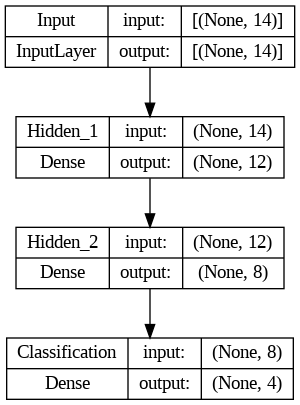

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(mlp_model, show_shapes=True)

Define loss function and optimzer

In [ ]:
loss_fn = SparseCategoricalCrossentropy()
optim_fn = Adam(learning_rate=0.001)
mlp_model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['acc'])

Training

In [ ]:
mlp_history = mlp_model.fit(
    x_train_scaled,
    y_train,
    batch_size = 16,
    epochs = 20,
    validation_data = (x_val_scaled, y_val)
)

Epoch 1/20
46/46 [==============================] - 5s 26ms/step - loss: 1.2376 - acc: 0.4252 - val_loss: 1.0362 - val_acc: 0.6016
Epoch 2/20
46/46 [==============================] - 0s 10ms/step - loss: 1.0147 - acc: 0.6025 - val_loss: 0.8687 - val_acc: 0.6250
Epoch 3/20
46/46 [==============================] - 0s 6ms/step - loss: 0.8772 - acc: 0.7701 - val_loss: 0.7471 - val_acc: 0.9453
Epoch 4/20
46/46 [==============================] - 0s 5ms/step - loss: 0.7469 - acc: 0.9155 - val_loss: 0.6202 - val_acc: 0.9688
Epoch 5/20
46/46 [==============================] - 0s 6ms/step - loss: 0.6070 - acc: 0.9723 - val_loss: 0.4806 - val_acc: 0.9844
Epoch 6/20
46/46 [==============================] - 0s 6ms/step - loss: 0.4489 - acc: 0.9972 - val_loss: 0.3280 - val_acc: 1.0000
Epoch 7/20
46/46 [==============================] - 0s 6ms/step - loss: 0.2912 - acc: 1.0000 - val_loss: 0.1930 - val_acc: 1.0000
Epoch 8/20
46/46 [==============================] - 0s 10ms/step - loss: 0.1791 - acc: 1

Plot Accuracy and Loss during training

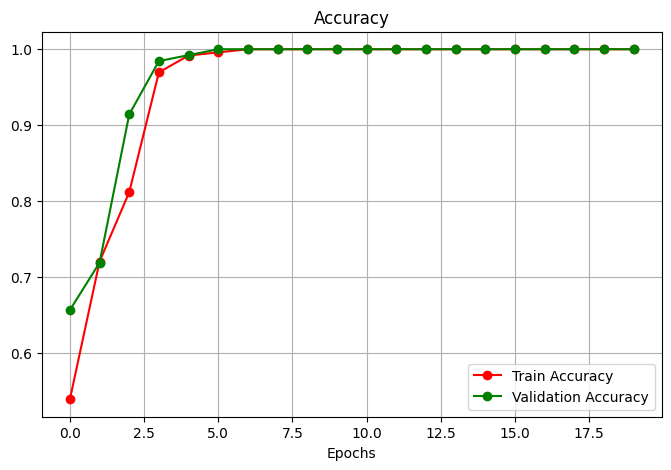

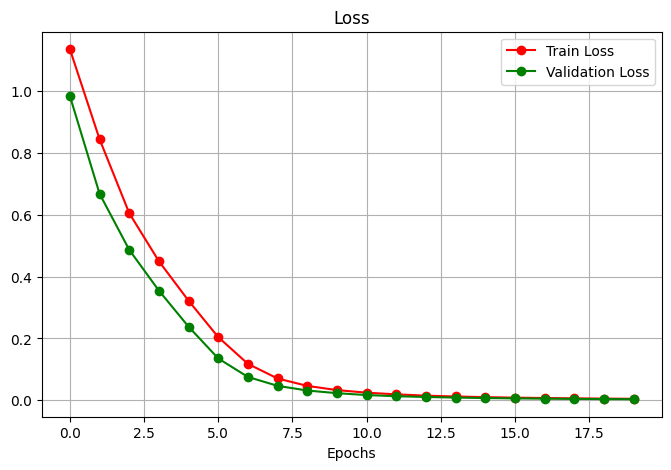

In [ ]:
# Train
train_acc = mlp_history.history['acc']
train_loss = mlp_history.history['loss']
# Validation
val_acc = mlp_history.history['val_acc']
val_loss = mlp_history.history['val_loss']

# Plotting section
# Accuracy
plt.figure(figsize=(8,5))
plt.plot(train_acc, 'r-o', label='Train Accuracy')
plt.plot(val_acc, 'g-o', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
# Loss
plt.figure(figsize=(8,5))
plt.plot(train_loss, 'r-o', label='Train Loss')
plt.plot(val_loss, 'g-o', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()

Classification reprot

In [ ]:
y_hat_train_ = mlp_model.predict(x_train_scaled)
y_hat_train = np.argmax(y_hat_train_, axis=1)
y_hat_val_ = mlp_model.predict(x_val_scaled)
y_hat_val = np.argmax(y_hat_val_, axis=1)

4/4 [==============================] - 0s 6ms/step


In [47]:
from sklearn.metrics import classification_report

In [ ]:
target_names = ['normal', 'inner brace fault', 'ball fault', 'outter brace fault']

report_train = classification_report(y_train, y_hat_train, target_names = target_names)
report_val = classification_report(y_val, y_hat_val, target_names = target_names)

print('Classification report for Train data is:\n')
print(report_train, end='\n\n')
print('Classification report for Validation data is:\n')
print(report_val, end='\n\n')

Classification report for Train data is:

                    precision    recall  f1-score   support

            normal       1.00      1.00      1.00       183
 inner brace fault       1.00      1.00      1.00       192
        ball fault       1.00      1.00      1.00       174
outter brace fault       1.00      1.00      1.00       173

          accuracy                           1.00       722
         macro avg       1.00      1.00      1.00       722
      weighted avg       1.00      1.00      1.00       722


Classification report for Validation data is:

                    precision    recall  f1-score   support

            normal       1.00      1.00      1.00        36
 inner brace fault       1.00      1.00      1.00        22
        ball fault       1.00      1.00      1.00        31
outter brace fault       1.00      1.00      1.00        39

          accuracy                           1.00       128
         macro avg       1.00      1.00      1.00       128
     

In [ ]:
y_hat_test_ = mlp_model.predict(x_test_scaled)
y_hat_test = np.argmax(y_hat_test_, axis=1)

5/5 [==============================] - 0s 4ms/step


In [ ]:
report_test = classification_report(y_test, y_hat_test, target_names = target_names)

print('Classification report for Test data is:\n')
print(report_test)

Classification report for Test data is:

                    precision    recall  f1-score   support

            normal       1.00      1.00      1.00        31
 inner brace fault       1.00      1.00      1.00        36
        ball fault       1.00      1.00      1.00        45
outter brace fault       1.00      1.00      1.00        38

          accuracy                           1.00       150
         macro avg       1.00      1.00      1.00       150
      weighted avg       1.00      1.00      1.00       150



## 2-3: other cost function and optimizer

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.optimizers import SGD

Preprocessing

In [ ]:
# Turn 1-D array into one-hot-encoded labels
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)


# compile the model
loss_fn_1 = KLDivergence()
optimizer_1 = SGD(learning_rate=0.001)
mlp_model_1.compile(
    loss = loss_fn_1,
    optimizer = optimizer_1,
    metrics = 'acc'
)

Train 2nd model

In [ ]:
mlp_history_1 = mlp_model_1.fit(
    x_train_scaled,
    y_train_one_hot,
    batch_size = 16,
    epochs = 20,
    validation_data = (x_val_scaled, y_val_one_hot)
)

Epoch 1/20
46/46 [==============================] - 1s 6ms/step - loss: 1.3333 - acc: 0.4668 - val_loss: 1.2627 - val_acc: 0.5547
Epoch 2/20
46/46 [==============================] - 0s 3ms/step - loss: 1.2776 - acc: 0.4889 - val_loss: 1.2064 - val_acc: 0.5781
Epoch 3/20
46/46 [==============================] - 0s 3ms/step - loss: 1.2312 - acc: 0.4903 - val_loss: 1.1591 - val_acc: 0.5781
Epoch 4/20
46/46 [==============================] - 0s 3ms/step - loss: 1.1921 - acc: 0.4917 - val_loss: 1.1183 - val_acc: 0.5859
Epoch 5/20
46/46 [==============================] - 0s 3ms/step - loss: 1.1579 - acc: 0.4931 - val_loss: 1.0808 - val_acc: 0.5859
Epoch 6/20
46/46 [==============================] - 0s 3ms/step - loss: 1.1264 - acc: 0.4931 - val_loss: 1.0465 - val_acc: 0.5859
Epoch 7/20
46/46 [==============================] - 0s 3ms/step - loss: 1.0975 - acc: 0.4931 - val_loss: 1.0149 - val_acc: 0.5859
Epoch 8/20
46/46 [==============================] - 0s 3ms/step - loss: 1.0708 - acc: 0.49

Plot Accuracy and Loss during training

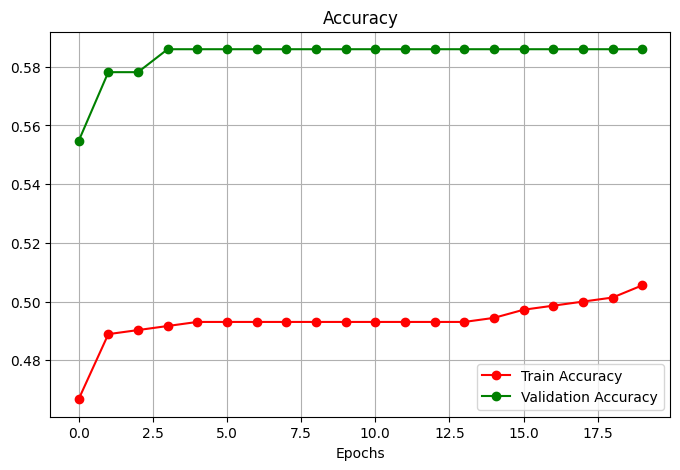

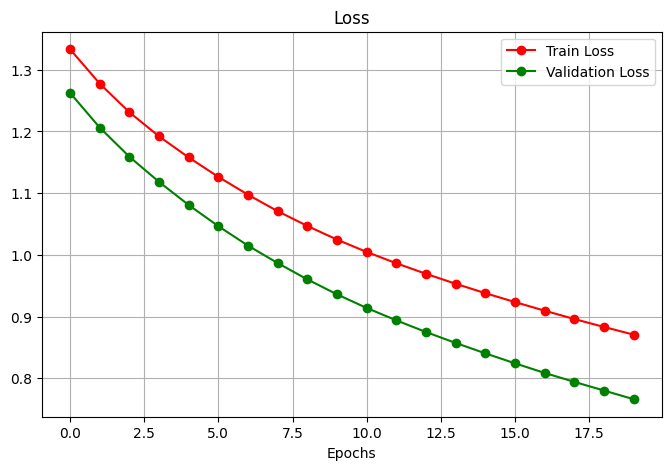

In [ ]:
# Train
train_acc = mlp_history_1.history['acc']
train_loss = mlp_history_1.history['loss']
# Validation
val_acc = mlp_history_1.history['val_acc']
val_loss = mlp_history_1.history['val_loss']

# Plotting section
# Accuracy
plt.figure(figsize=(8,5))
plt.plot(train_acc, 'r-o', label='Train Accuracy')
plt.plot(val_acc, 'g-o', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
# Loss
plt.figure(figsize=(8,5))
plt.plot(train_loss, 'r-o', label='Train Loss')
plt.plot(val_loss, 'g-o', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()

In [ ]:
y_hat_train_ = mlp_model_1.predict(x_train_scaled)
y_hat_train = np.argmax(y_hat_train_, axis=1)
y_hat_val_ = mlp_model_1.predict(x_val_scaled)
y_hat_val = np.argmax(y_hat_val_, axis=1)

4/4 [==============================] - 0s 3ms/step


In [ ]:
from sklearn.metrics import classification_report

target_names = ['normal', 'inner brace fault', 'ball fault', 'outter brace fault']

report_train = classification_report(y_train, y_hat_train, target_names = target_names)
report_val = classification_report(y_val, y_hat_val, target_names = target_names)

print('Classification report for Train data is:\n')
print(report_train, end='\n\n')
print('Classification report for Validation data is:\n')
print(report_val, end='\n\n')

Classification report for Train data is:

                    precision    recall  f1-score   support

            normal       0.53      1.00      0.69       183
 inner brace fault       0.00      0.00      0.00       192
        ball fault       1.00      0.06      0.11       174
outter brace fault       0.47      1.00      0.64       173

          accuracy                           0.51       722
         macro avg       0.50      0.51      0.36       722
      weighted avg       0.49      0.51      0.36       722


Classification report for Validation data is:

                    precision    recall  f1-score   support

            normal       0.54      1.00      0.70        36
 inner brace fault       0.00      0.00      0.00        22
        ball fault       0.00      0.00      0.00        31
outter brace fault       0.64      1.00      0.78        39

          accuracy                           0.59       128
         macro avg       0.29      0.50      0.37       128
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
y_hat_test_ = mlp_model_1.predict(x_test_scaled)
y_hat_test = np.argmax(y_hat_test_, axis=1)

5/5 [==============================] - 0s 6ms/step


In [ ]:
report_test = classification_report(y_test, y_hat_test, target_names = target_names)

print('Classification report for Test data is:\n')
print(report_test)

Classification report for Test data is:

                    precision    recall  f1-score   support

            normal       0.43      1.00      0.60        31
 inner brace fault       0.00      0.00      0.00        36
        ball fault       1.00      0.09      0.16        45
outter brace fault       0.51      1.00      0.68        38

          accuracy                           0.49       150
         macro avg       0.49      0.52      0.36       150
      weighted avg       0.52      0.49      0.35       150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2-4: Stratified K-Fold Cross-validation

In [31]:
from sklearn.model_selection import KFold, StratifiedKFold

RandomState(MT19937) at 0x7FE780CE0540

In [19]:
# Define the network
def network():

    # Model architecture
    model = Sequential(
        [
            Input(shape=(14,), name='Input'),
            Dense(units=12, activation='relu', name='Hidden_1'),
            Dense(units=8, activation='relu', name='Hidden_2'),
            Dense(units=4, activation='softmax', name='Classification')
        ]
    )
    # Compiling model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=SparseCategoricalCrossentropy()
    )

    return model

In [49]:
# K-fold model
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)

fold_acc = {'train':[], 'val':[]}
fold_loss = {'train':[], 'val':[]}
all_models = []
all_losses = []

# Train model
for train_index, val_index in tqdm.tqdm(kf.split(x_train_scaled,y_train)):
    X_train_fold, X_val_fold = x_train_scaled[train_index], x_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train selected folds
    model = network()
    history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=16, verbose=0, validation_data=(X_val_fold, y_val_fold))

    # Accuracy
    train_hat = model.predict(X_train_fold, verbose=0)
    train_hat = np.argmax(train_hat,axis=1).reshape(-1,)
    train_hat = train_hat == y_train_fold
    train_score = np.sum(train_hat.astype('float64'))/len(y_train_fold)
    fold_acc['train'].append(train_score)

    val_hat = model.predict(X_val_fold, verbose=0)
    val_hat = np.argmax(val_hat, axis=1).reshape(-1,)
    val_hat = val_hat == y_val_fold
    val_score = np.sum(val_hat.astype('float64'))/len(y_val_fold)
    fold_acc['val'].append(val_score)

    # Loss
    train_loss = history.history['loss'][-1]
    fold_loss['train'].append(train_loss)

    val_loss = history.history['val_loss'][-1]
    fold_loss['val'].append(val_loss)

    # Saving all models
    all_models.append(model)
    all_losses.append(val_loss)



5it [00:18,  3.65s/it]


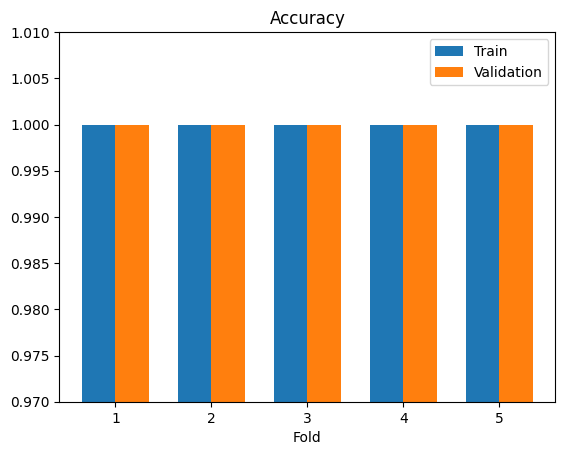

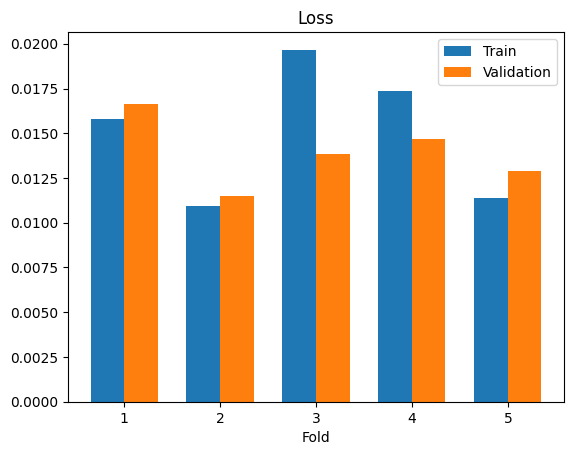

In [50]:
x_axis = np.array(list(range(5))).astype('float32') + 1
width = 0.35

# Accuracy
fig, ax = plt.subplots()
plt.bar(x_axis-width/2, fold_acc['train'], width, label='Train')
plt.bar(x_axis+width/2, fold_acc['val'], width, label='Validation')
plt.title('Accuracy')
plt.xlabel('Fold')
plt.legend(loc='upper right')
plt.ylim([0.97,1.01])

# Loss
fig, ax = plt.subplots()
plt.bar(x_axis-width/2, fold_loss['train'], width, label='Train')
plt.bar(x_axis+width/2, fold_loss['val'], width, label='Validation')
plt.title('Loss')
plt.xlabel('Fold')
plt.legend(loc='upper right')
# plt.ylim([0.97,1.01])


In [51]:
best = np.argmin(all_losses)
y_hat_test_2_ = all_models[best].predict(x_test_scaled)
y_hat_test_2 = np.argmax(y_hat_test_2_, axis=1)

5/5 [==============================] - 0s 3ms/step


In [52]:
final_model_test = classification_report(y_test, y_hat_test_2)

print('Classification report for Test data is:\n')
print(final_model_test)

Classification report for Test data is:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        36
           2       1.00      1.00      1.00        45
           3       1.00      1.00      1.00        38

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

